# TEDA (Typicality & Eccentricity Data Analysis) — Bootcamp Notebook

This notebook provides a step-by-step guide to applying **TEDA** on annotated energy time series (LEAD 1.0). 

We will cover the following topics:
1) loading and preparing the data;  
2) running TEDA (offline) with different sensitivities;  
3) comparing with anomaly labels;  
4) visualizations (time series + sensitivity to parameter *m* + confusion matrix).

> **Tip**: Run the cells in order. Plots and CSVs are saved in the current directory.

## ⚙️ Requirements

- Python 3.x  
- Libraries: `pandas`, `numpy`, `matplotlib`, `scikit-learn`  
- Files in the same folder as the notebook:  
  - `lead1.0-small.csv`  
  - `teda.py` (containing the class `TEDA(threshold)` with `.run_offline(df, features)`)

> If in a new environment, install dependencies:  
> `pip install pandas numpy matplotlib scikit-learn seaborn plotly openpyxl`

In [1]:
### External classes

import numpy as np


class TEDA:
    """Class used to detect outliers on the dataset"""
    # ------------------------------
    # CONSTRUCTOR
    #-------------------------------
    def __init__(self, threshold):
        # initialize variables
        self.k = 1
        self.variance = 0
        self.mean = 0
        self.threshold = threshold

    # ------------------------------
    # INTERNAL METHODS
    #-------------------------------
    def __calcMean(self, x):
        return ((self.k-1)/self.k)*self.mean + (1/self.k)*x

    def __calcVariance(self, x):
        distance_squared = np.square(np.linalg.norm(x - self.mean))
        return ((self.k-1)/self.k)*self.variance + distance_squared*(1/(self.k - 1))

    def __calcEccentricity(self, x):
        if(self.variance == 0):
            self.variance = 0.00001

        if (isinstance(x, float)):
            return (1 / self.k) +  (((self.mean - x)*(self.mean - x)) / (self.k *  self.variance))
        else:
            return (1 / self.k) +  (((self.mean - x).T.dot((self.mean - x))) / (self.k *  self.variance))



    # ------------------------------
    # RUN METHODS
    #-------------------------------
    def run_offline(self, df, features):
        """Run the algorithm offline"""

        # add is_outlier column to the dataframe
        df['is_outlier'] = 0

        # loop through the rows in df
        for index, row in df.iterrows():
            # build the X sample numpy array
            x = np.array(row[features])

            # update the model metrics
            if(self.k == 1):
                self.mean = x
                self.variance = 0
            else:
                # calculate the new mean
                self.mean = self.__calcMean(x)
                # calculate the new variance
                self.variance = self.__calcVariance(x)
                # calculate the eccentricity and normalized eccentricity
                eccentricity = self.__calcEccentricity(x)
                norm_eccentricity = eccentricity/2
                # define the threshold for outlier detection
                threshold_ = (self.threshold**2 +1)/(2*self.k)

                # check if the point is an outlier
                isOutlier = norm_eccentricity > threshold_

                # if the point is an outlier, add it to the outlier list
                if (isOutlier):
                    df.at[index, 'is_outlier'] = 1

            # Update the timestamp
            self.k = self.k + 1


    def run(self, x):
        "Run the algorithm online"""

        is_outlier = 0

        # update the model metrics
        if(self.k == 1):
            self.mean = x
            self.variance = 0
            #is_outlier = 1
        else:
            # calculate the new mean
            self.mean = self.__calcMean(x)
            # calculate the new variance
            self.variance = self.__calcVariance(x)
            # calculate the eccentricity and nomalized eccentricity
            eccentricity = self.__calcEccentricity(x)
            norm_eccentricity = eccentricity/2
            # define the threshold for outlier detection
            threshold_ = (self.threshold**2 +1)/(2*self.k)

            # check if the point is an outlier
            isOutlier = norm_eccentricity > threshold_

            # if the sample is an outlier, add it to the outlier list
            if (isOutlier):
                is_outlier = 1

        # Update the timestamp
        self.k = self.k + 1

        return is_outlier

In [2]:
class RLSFilter:
    """
    Adaptive RLS filter.

    **Args:**

    * `n` : length of filter (integer) - how many input is input array
      (row of input matrix)

    **Kwargs:**

    * `mu` : forgetting factor (float). It is introduced to give exponentially
      less weight to older error samples. It is usually chosen
      between 0.98 and 1.

    * `delta` : regularization factor (float). It is usually chosen
      between 0.1 and 1.

    * `w` : initial weights of filter. Possible values are:

        * array with initial weights (1 dimensional array) of filter size

        * "zeros" : create zero value weights
    """

    def __init__(self, n=2, mu=0.99, delta=0.1, w=np.zeros(2)):
        if type(n) == int:
            self.n = n
        else:
            raise ValueError('The size of filter must be an integer')

        if ((mu <= 0) or (mu > 1)):
            raise ValueError('The forgetting factor must be between 0 an 1')
        else:
            self.mu = mu

        self.delta = delta
        self.w = w


        self.P = 1/self.delta * np.identity(n)
        self.dw = np.zeros(len(self.w))

    def update(self, d, x):
        """
        Update filter - adapting weights according to desired value and its input.

        **Args:**

        * `d` : desired value (float)

        * `x` : input array (1-dimensional array)
        """
        y = np.dot(self.w, x)
        e = d - y
        P1 = np.dot(np.dot(np.dot(self.P,x),x.T),self.P)
        P2 = self.mu + np.dot(np.dot(x,self.P),x.T)
        self.P = 1/self.mu * (self.P - P1/P2)
        self.dw = np.dot(self.P, x.T) * e
        self.w += self.dw

    def filter(self, x):
        """
        This function calculates the new output value `y` from input array `x`.

        **Args:**

        * `x` : input vector (1 dimension array) in length of filter.

        **Returns:**

        * `y` : output value (float) calculated from input array.

        """
        y = np.dot(self.w, x)
        return y

## 🔧 Parameters (edit here)

Choose the **building**, **time window**, and **TEDA sensitivity**.  
For the class, you can start with one of the suggested buildings/windows and vary `M_DEFAULT` and the list `MS`.

> The higher the `M_DEFAULT`, the fewer anomalies will be detected.

In [3]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Main parameters
BUILDING_ID = 263
START = "2016-01-16 00:00:00"
END   = "2016-01-18 23:59:59"

# TEDA sensitivity
M_DEFAULT = 0.15
MS = [0.05, 0.10, 0.15, 0.20, 0.25]

# Files
DATA_PATH = "./lead1.0-small.csv"

print(f"Config: building={BUILDING_ID}, window=({START} → {END}), m0={M_DEFAULT}, sweep={MS}")


Config: building=263, window=(2016-01-16 00:00:00 → 2016-01-18 23:59:59), m0=0.15, sweep=[0.05, 0.1, 0.15, 0.2, 0.25]


## 📥 Load data and filter window
- Convert `timestamp` to `datetime`.
- Filter by `BUILDING_ID` and by the window `[START, END]`.

In [4]:

# 1) Load data
df = pd.read_csv(DATA_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filter building and window
mask = (
    (df["building_id"] == BUILDING_ID) &
    (df["timestamp"] >= pd.to_datetime(START)) &
    (df["timestamp"] <= pd.to_datetime(END))
)
df1 = df.loc[mask].copy()

print(df1.head())
print("Shape:", df1.shape)


       building_id           timestamp  meter_reading  anomaly
71531          263 2016-01-16 00:00:00          56.44        1
71731          263 2016-01-16 01:00:00          56.32        1
71930          263 2016-01-16 02:00:00          57.08        1
72130          263 2016-01-16 03:00:00          55.82        1
72330          263 2016-01-16 04:00:00          53.69        1
Shape: (72, 4)


## 🧠 Import TEDA
The file `teda.py` must be in the same directory. It needs to expose the class `TEDA(threshold)` with the method `run_offline(df, features)`.

In [5]:
# 2) Utility function to apply TEDA
def apply_teda(g: pd.DataFrame, m: float) -> pd.DataFrame:
    g = g.sort_values("timestamp").reset_index(drop=True)
    work = g[["meter_reading"]].copy()
    model = TEDA(threshold=m)
    model.run_offline(work, features=["meter_reading"])  # adds 'is_outlier' column
    g = g.copy()
    g["teda_outlier"] = work["is_outlier"].astype(int).values
    return g


## ▶️ Run TEDA (m = `M_DEFAULT`)
We also compute the metrics against the `anomaly` label.



In [6]:

# 4) Run TEDA (m = M_DEFAULT)
res = apply_teda(df1, m=M_DEFAULT)

# 5) MMetrics
y_true = res["anomaly"].astype(int).values
y_pred = res["teda_outlier"].astype(int).values
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print(f"[Building {BUILDING_ID} | {START} → {END} | m={M_DEFAULT}]")
print(f"Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")

[Building 263 | 2016-01-16 00:00:00 → 2016-01-18 23:59:59 | m=0.15]
Precision=1.000  Recall=0.944  F1=0.971


## 🧩 Confusion matrix (m = `M_DEFAULT`)
Helps interpret the trade-off between false positives and false negatives.

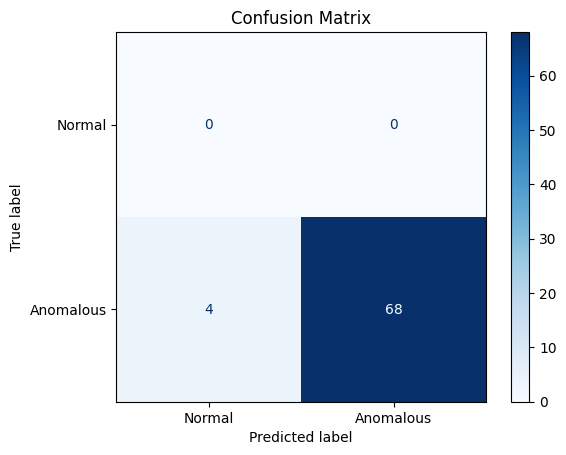

In [7]:
# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Normal", "Anomalous"])
disp.plot(values_format="d", cmap="Blues", colorbar=True)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

## 📈 Time series with labels and TEDA detections
Marks the labels (`anomaly=1`) and TEDA detections.

<function matplotlib.pyplot.show(close=None, block=None)>

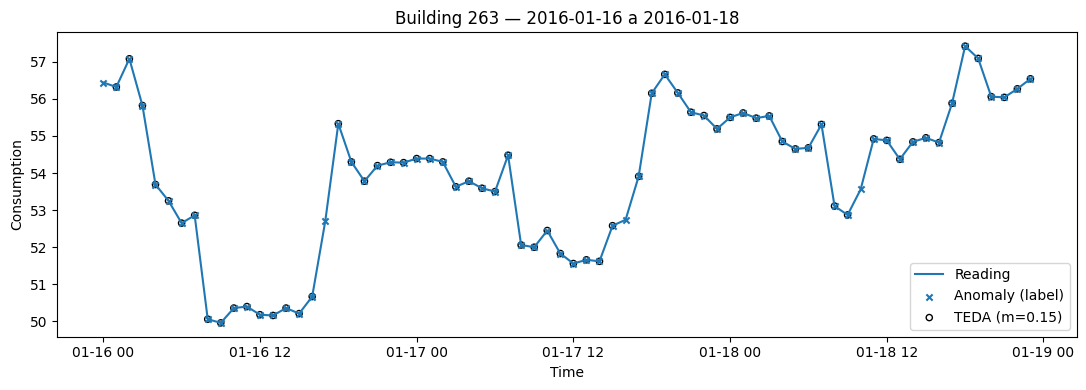

In [8]:

# 6) Time Series
plt.figure(figsize=(11,4))
plt.plot(res["timestamp"], res["meter_reading"], label="Reading")
plt.scatter(res.loc[res["anomaly"]==1, "timestamp"], res.loc[res["anomaly"]==1, "meter_reading"],
            marker="x", s=20, label="Anomaly (label)", zorder=3)
plt.scatter(res.loc[res["teda_outlier"]==1, "timestamp"], res.loc[res["teda_outlier"]==1, "meter_reading"],
            facecolors="none", edgecolors="k", s=20, label=f"TEDA (m={M_DEFAULT})")
plt.title(f"Building {BUILDING_ID} — {START[:10]} a {END[:10]}")
plt.xlabel("Time"); plt.ylabel("Consumption")
plt.legend(); plt.tight_layout()
# plt.savefig(f"./serie_{BUILDING_ID}.png", dpi=180); plt.close()
# print("Figura salva:", f"./serie_{BUILDING_ID}.png")
plt.show

m sensitivity:
       m  precision    recall        f1
0  0.05        1.0  0.972222  0.985915
1  0.10        1.0  0.958333  0.978723
2  0.15        1.0  0.944444  0.971429
3  0.20        1.0  0.916667  0.956522
4  0.25        1.0  0.888889  0.941176


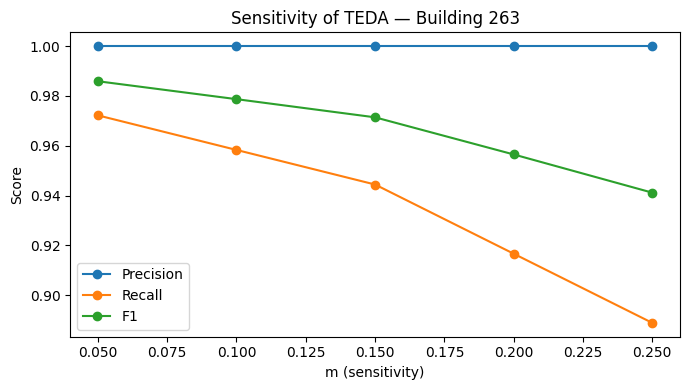

In [10]:
# 7) m sensitivity
mask = (
    (df["building_id"] == BUILDING_ID) &
    (df["timestamp"] >= pd.to_datetime(START)) &
    (df["timestamp"] <= pd.to_datetime(END))
)
df1 = df.loc[mask].copy()

rows = []
for m in MS:
    tmp = apply_teda(df1, m=m)
    p_i, r_i, f1_i, _ = precision_recall_fscore_support(
        tmp["anomaly"].astype(int).values,
        tmp["teda_outlier"].astype(int).values,
        average="binary", zero_division=0
    )
    rows.append((m, p_i, r_i, f1_i))

scores = pd.DataFrame(rows, columns=["m","precision","recall","f1"])
print("m sensitivity:\n", scores)

plt.figure(figsize=(7,4))
plt.plot(scores["m"], scores["precision"], marker="o", label="Precision")
plt.plot(scores["m"], scores["recall"], marker="o", label="Recall")
plt.plot(scores["m"], scores["f1"], marker="o", label="F1")
plt.xlabel("m (sensitivity)"); plt.ylabel("Score")
plt.title(f"Sensitivity of TEDA — Building {BUILDING_ID}")
plt.legend(); plt.tight_layout()
# plt.savefig(f"./sens_m_{BUILDING_ID}.png", dpi=180); plt.close()
# print("Figura salva:", f"./sens_m_{BUILDING_ID}.png")
plt.show()

## 💾 Save results per sample
Includes the column `teda_outlier` for later analysis.

In [11]:

# 9) Save CSV
res.to_csv(f"./teda_results_{BUILDING_ID}_{START[:10]}_{END[:10]}.csv", index=False)
print("CSV saved:", f"./teda_results_{BUILDING_ID}_{START[:10]}_{END[:10]}.csv")


CSV saved: ./teda_results_263_2016-01-16_2016-01-18.csv


## 🔎 Automatically discover good windows for demonstration
Finds 3-day windows with **anomalies and variation** (avoids “flat” series). Edit thresholds to refine.

In [12]:

WINDOW_DAYS = 3
MIN_ANOMS   = 3
MIN_CV      = 0.02
MIN_UNIQUE  = 0.15

df_all = pd.read_csv(DATA_PATH)
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"])
df_all = df_all.sort_values(["building_id","timestamp"])

def scan_building(df_b, window_days=WINDOW_DAYS):
    out = []
    days = pd.date_range(df_b["timestamp"].min().normalize(),
                         df_b["timestamp"].max().normalize(), freq="D")
    for start in days:
        end = start + pd.Timedelta(days=window_days) - pd.Timedelta(seconds=1)
        sel = (df_b["timestamp"] >= start) & (df_b["timestamp"] <= end)
        chunk = df_b.loc[sel].copy()
        if len(chunk) < 24:
            continue
        chunk = chunk.set_index("timestamp")
        chunk["meter_reading"] = chunk["meter_reading"].interpolate(method="time", limit_direction="both")
        chunk = chunk.reset_index()
        vals = chunk["meter_reading"].dropna().values
        if len(vals) == 0:
            continue
        mean = float(np.mean(vals))
        std  = float(np.std(vals))
        cv   = (std/mean) if mean != 0 else (np.inf if std>0 else 0.0)
        unique_ratio = pd.Series(vals).nunique() / len(vals)
        anoms = int(chunk["anomaly"].sum())
        if (anoms >= MIN_ANOMS) and (cv >= MIN_CV) and (unique_ratio >= MIN_UNIQUE):
            out.append({
                "building_id": int(df_b["building_id"].iloc[0]),
                "start": start, "end": end,
                "n_points": int(len(vals)),
                "anoms": anoms,
                "cv": round(cv, 4),
                "unique_ratio": round(unique_ratio, 3)
            })
    return out

anom_blds = df_all.loc[df_all["anomaly"]==1, "building_id"].unique().tolist()
cands = []
for b in anom_blds:
    cands.extend(scan_building(df_all[df_all["building_id"]==b].copy()))

cands = pd.DataFrame(cands).sort_values(["anoms","cv","unique_ratio"], ascending=[False, False, False]).reset_index(drop=True)
print("Top 10 windows with anomalies:")
cands.head(10)


Top 10 windows with anomalies:


,building_id,start,end,n_points,anoms,cv,unique_ratio
0,141,2016-12-27,2016-12-29 23:59:59,72,72,0.1428,0.514
1,190,2016-09-23,2016-09-25 23:59:59,72,72,0.0612,0.903
2,263,2016-01-16,2016-01-18 23:59:59,72,72,0.0366,0.944
3,254,2016-10-21,2016-10-23 23:59:59,72,69,1.3138,0.569
4,141,2016-12-28,2016-12-30 23:59:59,72,68,0.1427,0.583
5,653,2016-02-15,2016-02-17 23:59:59,72,68,0.1382,1.000
6,439,2016-12-24,2016-12-26 23:59:59,72,68,0.0591,1.000
7,1353,2016-11-23,2016-11-25 23:59:59,72,66,0.1898,0.639
8,1309,2016-07-17,2016-07-19 23:59:59,72,65,0.5202,0.222
9,190,2016-09-22,2016-09-24 23:59:59,72,65,0.3407,0.944


# 🏃 Quick exercises

Use this section to practice adjusting TEDA, compare buildings, and investigate errors.  
**Tip:** run the previous cells first (until generating `apply_teda`, `df`, `BUILDING_ID`, etc.).


## 1) Fine-tune `m` (sensitivity)
Change `M_DEFAULT` and quickly re-evaluate the metrics for the same building and window.

In [13]:

# TODO: adjust here and run
M_TRY = 0.08  # experiment: 0.03, 0.05, 0.08, 0.12, ...

mask = (
    (df["building_id"] == BUILDING_ID) &
    (df["timestamp"] >= pd.to_datetime(START)) &
    (df["timestamp"] <= pd.to_datetime(END))
)

df_try = df.loc[mask].copy()

res_try = apply_teda(df_try, m=M_TRY)
y_true = res_try["anomaly"].astype(int).values
y_pred = res_try["teda_outlier"].astype(int).values

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
print(f"[m={M_TRY}] Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")


[m=0.08] Precision=1.000 | Recall=0.972 | F1=0.986


## 2) Search for optimal `m` by F1 (simple grid)
Sweep several values of `m` and choose the best by F1 for **this building/window**.

In [14]:
m_grid = np.linspace(0.02, 0.20, 13)  # 0.02, 0.04, ..., 0.20
rows = []
for m in m_grid:
    tmp = apply_teda(df_try, m=float(m))
    p_i, r_i, f1_i, _ = precision_recall_fscore_support(
        tmp["anomaly"].astype(int).values,
        tmp["teda_outlier"].astype(int).values,
        average="binary",
        zero_division=0
    )
    rows.append((float(m), p_i, r_i, f1_i))
grid_scores = pd.DataFrame(rows, columns=["m","precision","recall","f1"]).sort_values("f1", ascending=False)
grid_scores.head(10)

,m,precision,recall,f1
0,0.020,1.0,0.972222,0.985915
1,0.035,1.0,0.972222,0.985915
2,0.050,1.0,0.972222,0.985915
3,0.065,1.0,0.972222,0.985915
4,0.080,1.0,0.972222,0.985915
5,0.095,1.0,0.972222,0.985915
6,0.110,1.0,0.958333,0.978723
7,0.125,1.0,0.944444,0.971429
8,0.140,1.0,0.944444,0.971429
9,0.155,1.0,0.944444,0.971429


## 3) Compare two buildings
Choose a **second building** with the respective time window and compare metrics/curves.


| building_id | start       | end                  | n_points | anoms |    cv   | unique_ratio |
|-------------|-------------|----------------------|----------|-------|---------|--------------|
| 141         | 2016-12-27  | 2016-12-29 23:59:59   | 72       | 72    | 0.1428  | 0.514        |
| 190         | 2016-09-23  | 2016-09-25 23:59:59   | 72       | 72    | 0.0612  | 0.903        |
| 263         | 2016-01-16  | 2016-01-18 23:59:59   | 72       | 72    | 0.0366  | 0.944        |
| 254         | 2016-10-21  | 2016-10-23 23:59:59   | 72       | 69    | 1.3138  | 0.569        |
| 141         | 2016-12-28  | 2016-12-30 23:59:59   | 72       | 68    | 0.1427  | 0.583        |
| 653         | 2016-02-15  | 2016-02-17 23:59:59   | 72       | 68    | 0.1382  | 1.000        |
| 439         | 2016-12-24  | 2016-12-26 23:59:59   | 72       | 68    | 0.0591  | 1.000        |
| 1353        | 2016-11-23  | 2016-11-25 23:59:59   | 72       | 66    | 0.1898  | 0.639        |
| 1309        | 2016-07-17  | 2016-07-19 23:59:59   | 72       | 65    | 0.5202  | 0.222        |
| 190         | 2016-09-22  | 2016-09-24 23:59:59   | 72       | 65    | 0.3407  | 0.944        |

In [15]:

# TODO: Choose a second building with anomalies in the same window START–END
BUILDING_ID_2 = BUILDING_ID  # change to another ID (See the table)
START = START
END = END

# Filter the second building
mask2 = (
    (df1["building_id"] == BUILDING_ID_2) &
    (df1["timestamp"] >= pd.to_datetime(START)) &
    (df1["timestamp"] <= pd.to_datetime(END))
)
df2 = df1.loc[mask2].copy().sort_values("timestamp")
df2 = df2.reset_index()

# Run TEDA on both with the same m
res1 = apply_teda(df1,  m=M_DEFAULT)    # building 1 (already filtered earlier)
res2 = apply_teda(df2, m=M_DEFAULT)    # building 2

def metrics_of(res):
    y_true = res["anomaly"].astype(int).values
    y_pred = res["teda_outlier"].astype(int).values
    return precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[:3]

p1, r1, f1 = metrics_of(res1)
p2, r2, f2 = metrics_of(res2)

print(f"Building {BUILDING_ID}:  P={p1:.3f} R={r1:.3f} F1={f1:.3f}")
print(f"Building {BUILDING_ID_2}: P={p2:.3f} R={r2:.3f} F1={f2:.3f}")


Building 263:  P=1.000 R=0.944 F1=0.971
Building 263: P=1.000 R=0.944 F1=0.971


## 4) Investigate **FP** and **FN**
List timestamps where TEDA flags an outlier but the label is 0 (FP), and where the label is 1 but TEDA does not detect (FN).

In [16]:

res_dbg = res.copy()
res_dbg["FP"] = ((res_dbg["teda_outlier"]==1) & (res_dbg["anomaly"]==0)).astype(int)
res_dbg["FN"] = ((res_dbg["teda_outlier"]==0) & (res_dbg["anomaly"]==1)).astype(int)

print("False positives (first 10):")
display(res_dbg.loc[res_dbg["FP"]==1, ["timestamp","meter_reading","anomaly","teda_outlier"]].head(10))

print("False negatives (first 10):")
display(res_dbg.loc[res_dbg["FN"]==1, ["timestamp","meter_reading","anomaly","teda_outlier"]].head(10))


False positives (first 10):


,timestamp,meter_reading,anomaly,teda_outlier


False negatives (first 10):


,timestamp,meter_reading,anomaly,teda_outlier
0,2016-01-16 00:00:00,56.44,1,0
17,2016-01-16 17:00:00,52.70,1,0
40,2016-01-17 16:00:00,52.74,1,0
58,2016-01-18 10:00:00,53.56,1,0


# 🧠 TEDA-RLS: Integration of TEDA with the RLS Filter

In this section, we explore how **TEDA (Typicality and Eccentricity Data Analytics)** 
can be combined with the **Recursive Least Squares (RLS) filter**.

- **TEDA** is used to detect anomalies in data streams.  
- **RLS** is used to recursively adjust parameters in regression problems.  
- The combination of both enables **real-time anomaly detection and correction**.  

### 📌 Main idea

1. **TEDA** identifies whether the new sample is **typical** or **eccentric**.  
2. If it is typical, the model update proceeds normally with **RLS**.  
3. If it is eccentric (potential outlier):  
   - RLS can be updated with lower weight;  
   - Or the sample can be discarded.  

In [17]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from random import randint, sample

## 📥 Load data

We will use a modified dataset obtained from a simulated distribution substation.  
The simulated data are based on the SCADA supervisory system, which recorded the active power value of the feeder (MW) every 15 minutes, totaling 96 measurements per day.  
In the dataset below, we will have 10 consecutive days.  


In [18]:
# Reading data
data = pd.read_excel("PowerWithOutliers.xlsx")
data.head()

print(data.head())

        Date      Hour      P  label  P with outliers
0 2010-01-01  00:00:00  770.0      0            770.0
1 2010-01-01  00:15:00  754.0      0            754.0
2 2010-01-01  00:30:00  754.0      0            754.0
3 2010-01-01  00:45:00  724.0      0            724.0
4 2010-01-01  01:00:00  724.0      0            724.0


In [19]:
# creating time series
ts = np.linspace(0, len(data), len(data))

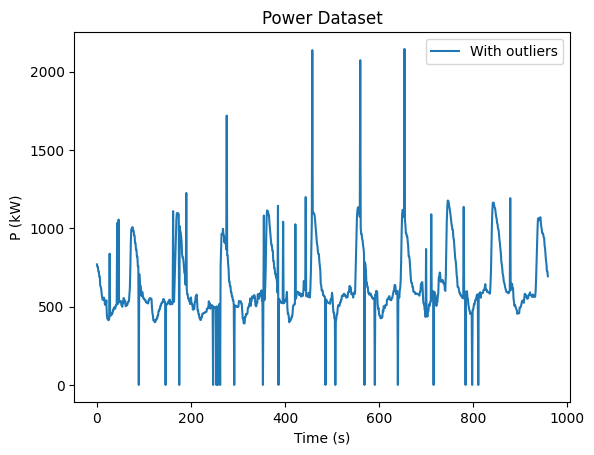

In [20]:
# Create figure and axis
fig, ax = plt.subplots()

# Plot the series
ax.plot(data.index, data['P with outliers'], label="With outliers")

# Axis and title settings
ax.set_title("Power Dataset")
ax.set_xlabel("Time (s)")
ax.set_ylabel("P (kW)")

# Show legend
ax.legend()

# Show the plot
plt.show()

## 📐 RLS Filter (Recursive Least Squares)

**RLS** is a recursive algorithm for real-time parameter estimation.  
It updates the **model weights** (θ) with each new sample $(x_k, y_k)$,
using the **forgetting factor** (λ) and the **covariance matrix** (P).

### 🔹 Parameters defined in the code

- `filter_order` → dimension of the input vector $x_k$  
- `forgetting_factor` → $\lambda$, forgetting factor (0.98–1)  
- `regularization_factor` → $\delta$, used in the initialization of $P_0$  
- `w0` → $\theta_0$, initial parameter vector  
- `X_ant` → $x_0$, initial input  

### 🔹 Internal variables of the RLS (computed automatically)

- $K_k$ → **Kalman gain**, adjusts the weight of the new sample (not a fixed parameter)  
- $\theta_k$ → parameter vector estimated by the filter  
- $P_k$ → covariance matrix, measures the uncertainty in the parameters  

### 🔹 RLS Equations

- **Kalman gain:**
$$
K_k = \frac{P_{k-1}x_k}{\lambda + x_k^T P_{k-1} x_k}
$$

- **Parameter update:**
$$
\theta_k = \theta_{k-1} + K_k \big(y_k - x_k^T \theta_{k-1}\big)
$$

- **Covariance matrix update:**
$$
P_k = \frac{1}{\lambda}\Big(P_{k-1} - K_k x_k^T P_{k-1}\Big)
$$


In [21]:
## Defining parameters

# TEDA
teda = TEDA(threshold=2.5)
correction = True   # Flag to correct consecutive outliers
N_outlier_max = 1   # Maximum number of outliers corrected by TEDA-RLS
FLAG = []

# RLS
filter_order = 4               # order of the filter (dimension of the input vector x_k)
forgetting_factor = 0.999      # λ (forgetting factor)
regularization_factor = 0.1    # δ (initial regularization factor)
w0 = np.zeros(filter_order)    # θ_0 (initial weights)
X_ant = np.zeros(filter_order) # x_0 (initial input)
rls_filter = RLSFilter(n=filter_order, mu=forgetting_factor, delta=regularization_factor, w=w0)

In [22]:
# Auxiliary vectors
Ya_py = []          # Auxiliary predicted values vector
Y_py = []           # Predicted values vector
DB = []             # Saved values vector (database)
outlier_count = 0   # Outlier count
y_pred_py = 0.0     # Initial predicted value

### 📌 Main idea

1. **TEDA** identifies whether the new sample is **typical** or **eccentric**.  
2. If it is typical, the model update proceeds normally with **RLS**.  
3. If it is eccentric (potential outlier):  
   - RLS can be updated with lower weight;  
   - Or the sample can be discarded.  

### 🔄 Recursive update in TEDA-RLS

TEDA computes the **eccentricity** and **typicality** of the new sample.  
These measures are used to decide **how much the sample should influence** the RLS update.

- **High eccentricity** → less reliable sample.  
- **High typicality** → reliable sample.  

In this way, RLS is not “contaminated” by outliers.  


In [23]:
for i in data['P with outliers']:
    ## Taking the current value
    valor_atual = i

    # Checking if it's an outlier
    flag = teda.run(valor_atual)
    FLAG.append(flag)

    ## First stage: Outlier correction
    if (flag == 1):
        outlier_count = outlier_count + 1
        valor_atual = y_pred_py
    else:
        outlier_count = 0

    # Evaluating the outlier flood
    if(correction == True and outlier_count == N_outlier_max + 1):
        valor_atual = i

    # Saving
    Ya_py.append(y_pred_py)

    # Updating weights
    rls_filter.update(valor_atual, np.array(X_ant))
    input_vector = []
    for j in X_ant[1:]:
        input_vector.append(j)
    input_vector.append(valor_atual)

    # Predicting the next value
    y_pred_py = rls_filter.filter(input_vector)
    Y_py.append(y_pred_py)

    # Second stage
    if (flag == 1):
        valor_atual = y_pred_py

    if(correction == True and outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual = i
    DB.append(valor_atual)

    # Updating the previous values vector
    X_ant = input_vector

data['flag_py'] = FLAG
#data['x_antp'] = data['x_ant']
data['save_py'] = DB
data['ya_pred_py'] = Ya_py
data['y_pred_py'] = Y_py

### 📊 Interpretation

- TEDA-RLS combines **robustness against anomalies** (TEDA)  
  with **efficiency in online regression** (RLS).  
- This enables applications in:  
  - Noisy time series  
  - Fault detection  
  - Real-time vehicular data  


In [24]:
def find_indices(list_to_check, item_to_find):
    """Find all indices of an item in a list."""
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

numberOfOutliersPython = data['flag_py'].sum()
print("Number of outliers detected: ", numberOfOutliersPython)

Number of outliers detected:  42


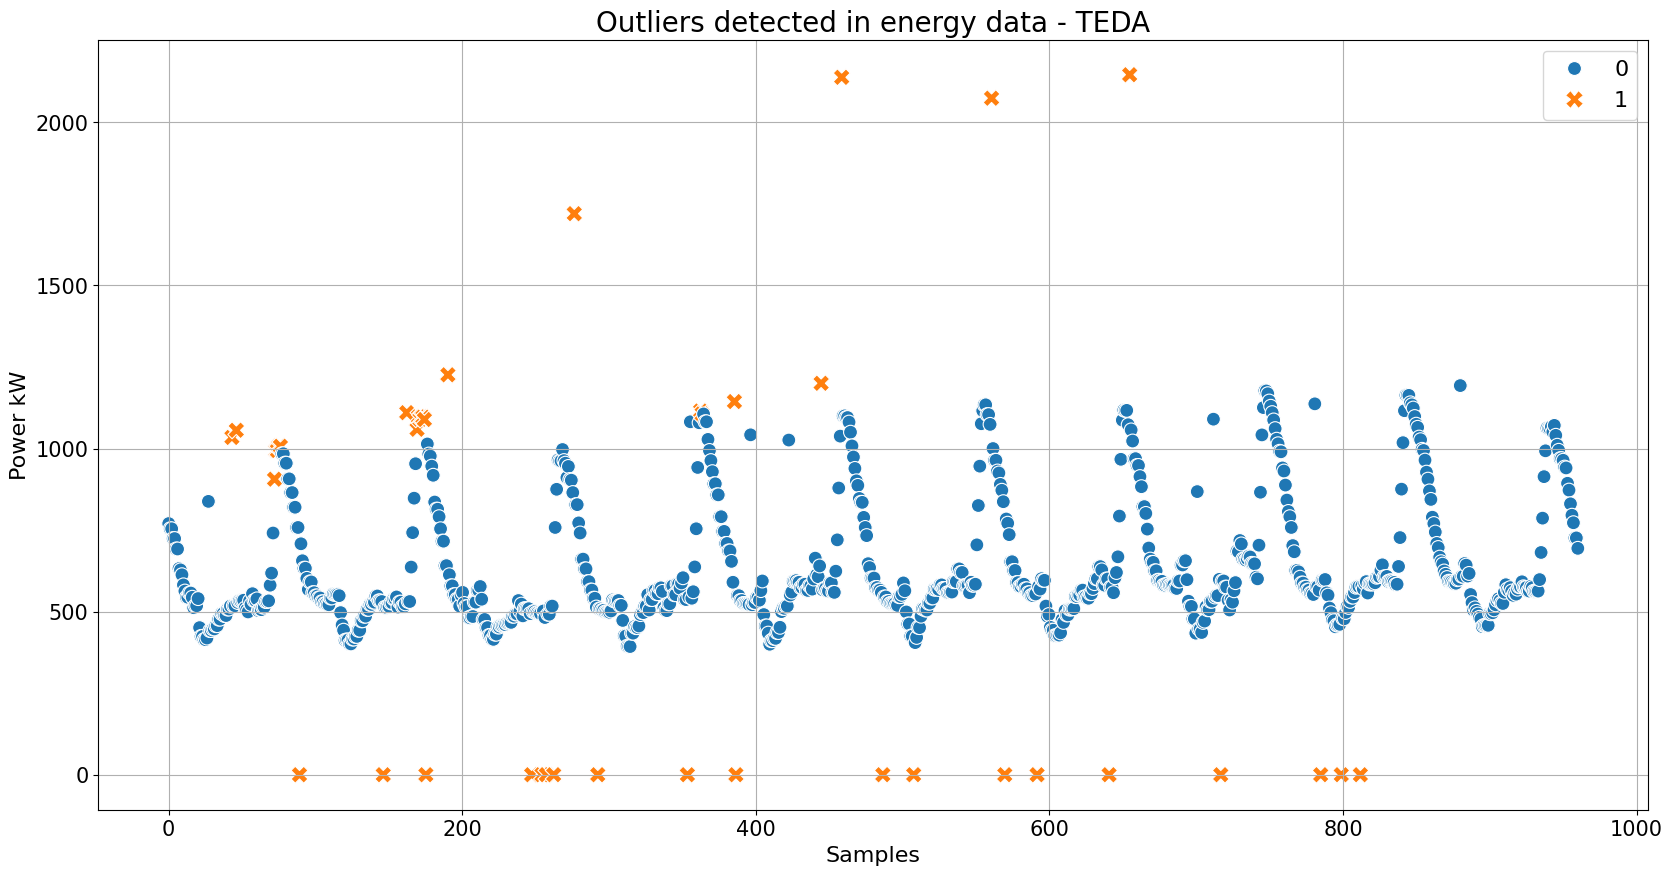

In [25]:
outliersIndexPython = find_indices(data['flag_py'], 1)

# TEDA results visualization
plt.figure(figsize=(20,10))
plt.grid()
plt.title("Outliers detected in energy data - TEDA", fontsize=20)
sns.scatterplot(x=ts, y=data['P with outliers'], hue=data['flag_py'], style=data['flag_py'], size=data['flag_py'], sizes=(150, 100))
plt.legend(fontsize=16)
plt.ylabel("Power kW", fontsize=16)
plt.xlabel("Samples", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

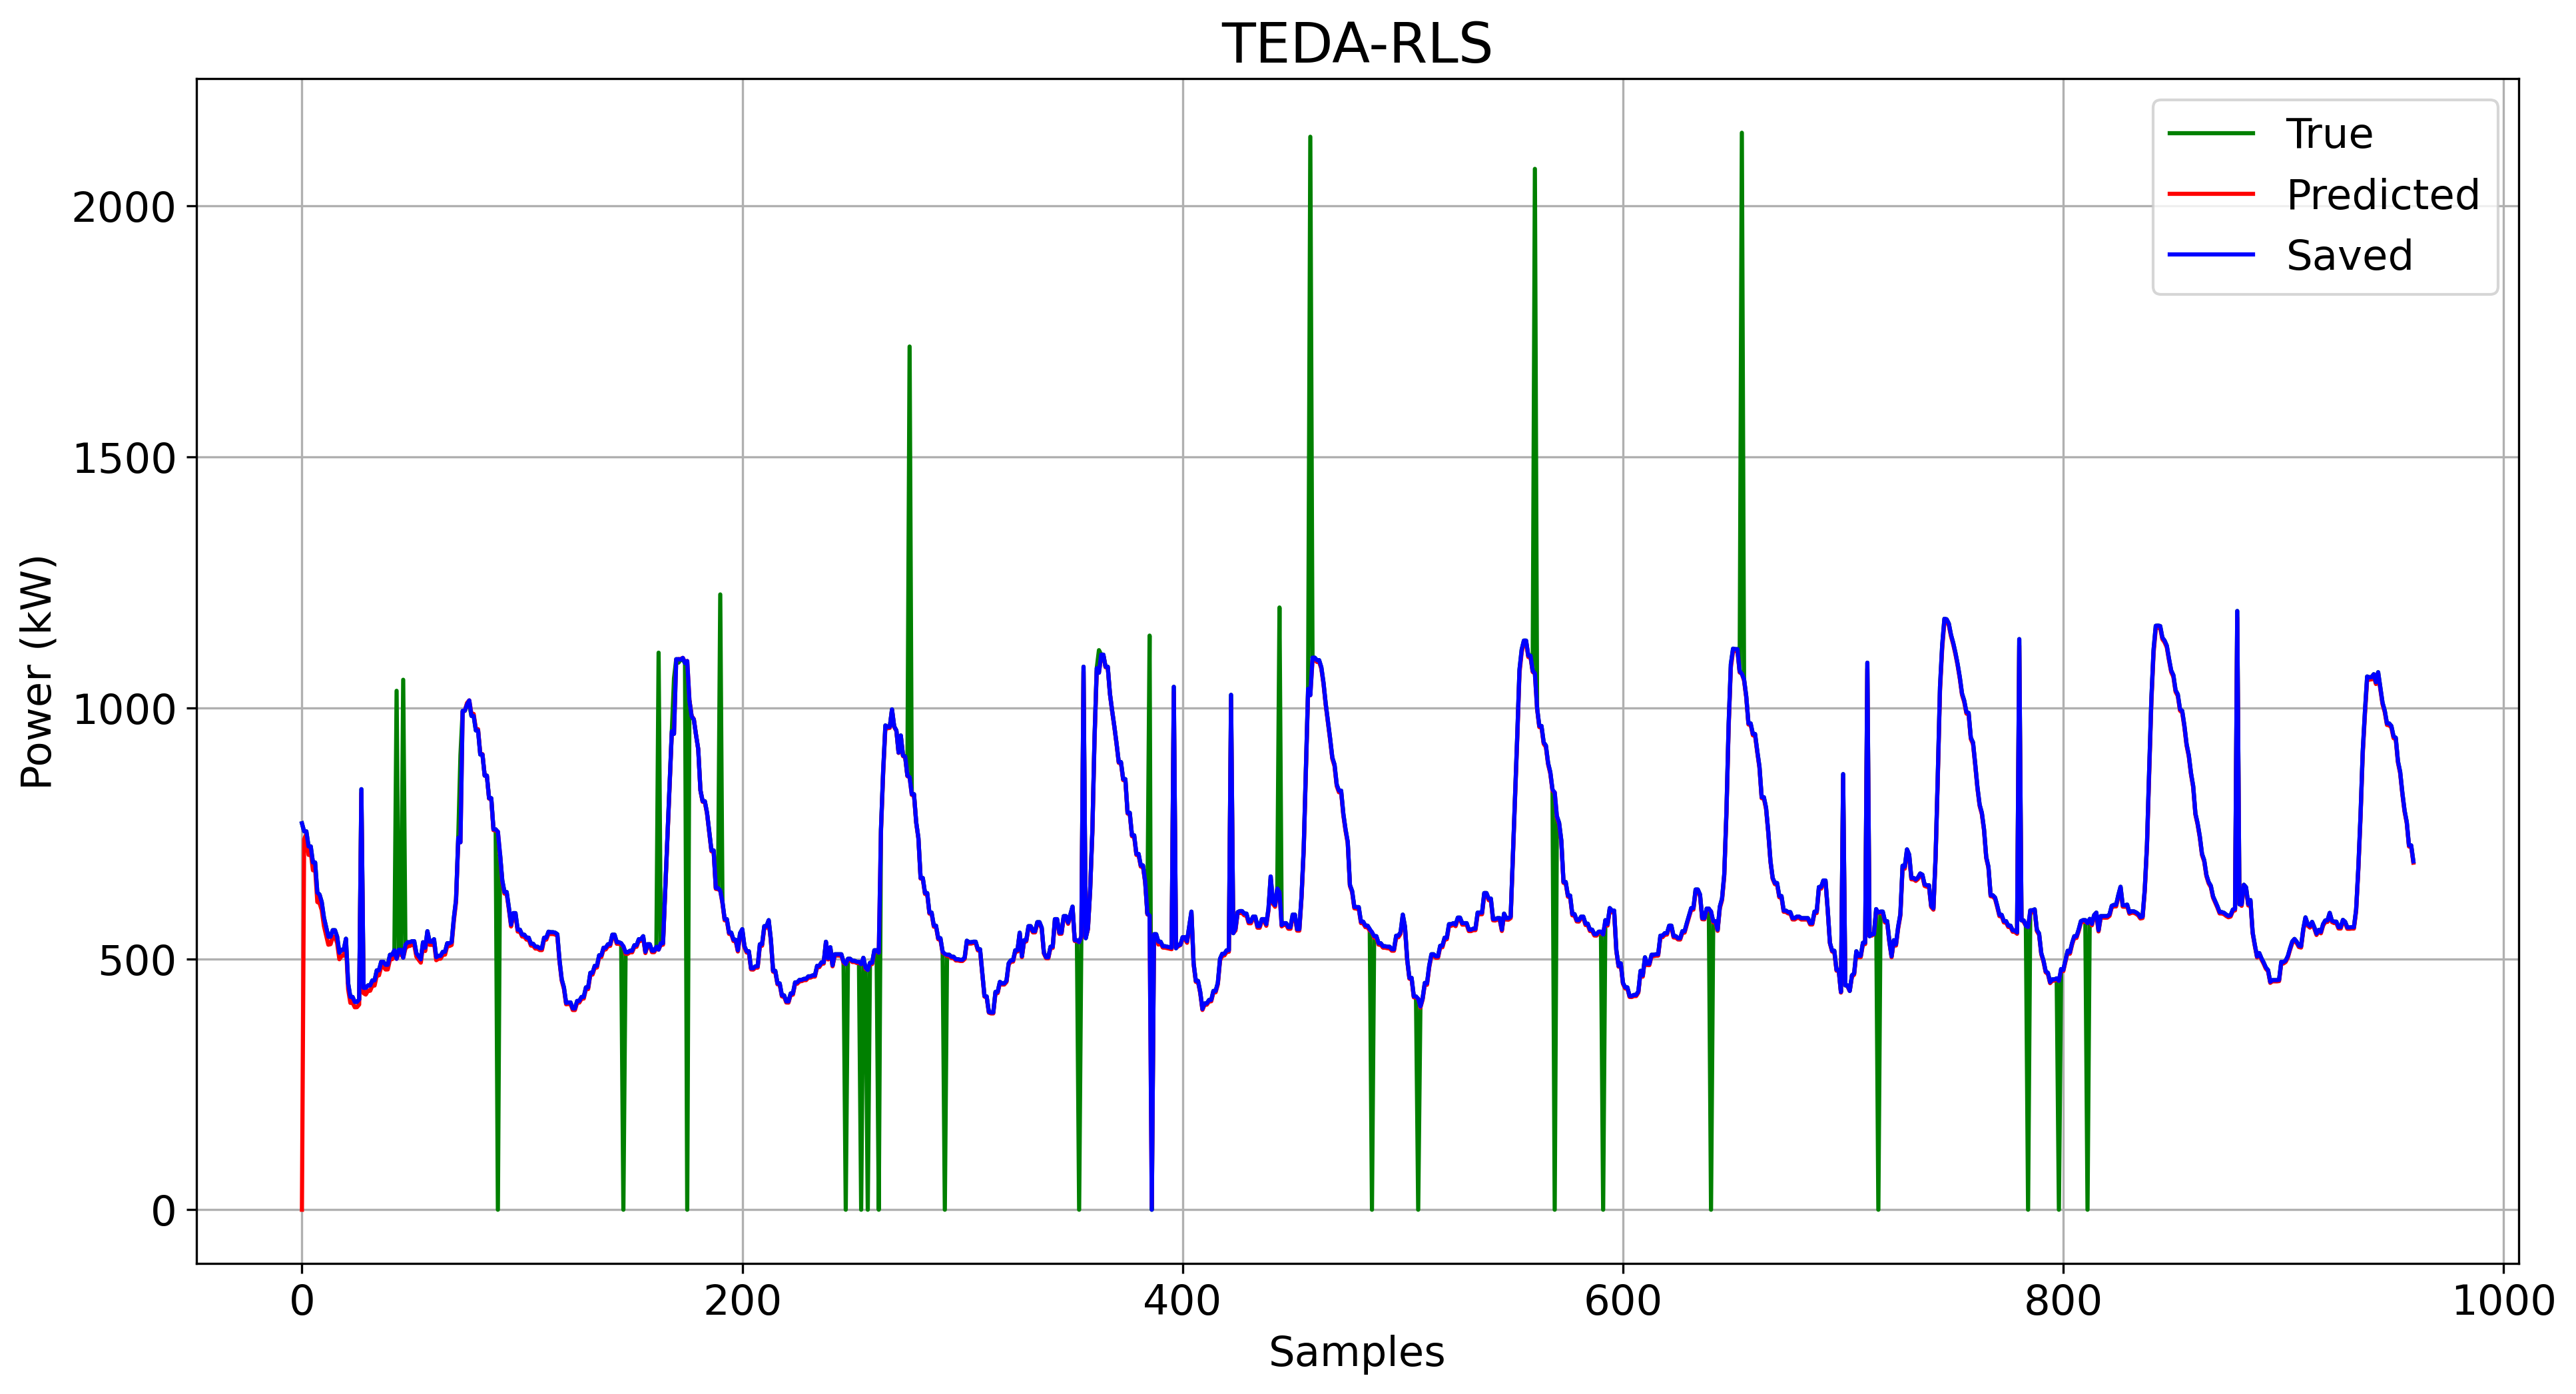

In [26]:
plt.figure(figsize=(15,7.7), dpi=300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.xlabel("Samples", fontsize=15)
plt.ylabel("Power (kW)", fontsize=15)
plt.plot(data['P with outliers'], 'g', label='True')
plt.plot(data['y_pred_py'], 'r', label='Predicted')
plt.plot(data['save_py'], 'b', label='Saved')
plt.legend(fontsize=15)
plt.title("TEDA-RLS", fontsize=20)
plt.show()

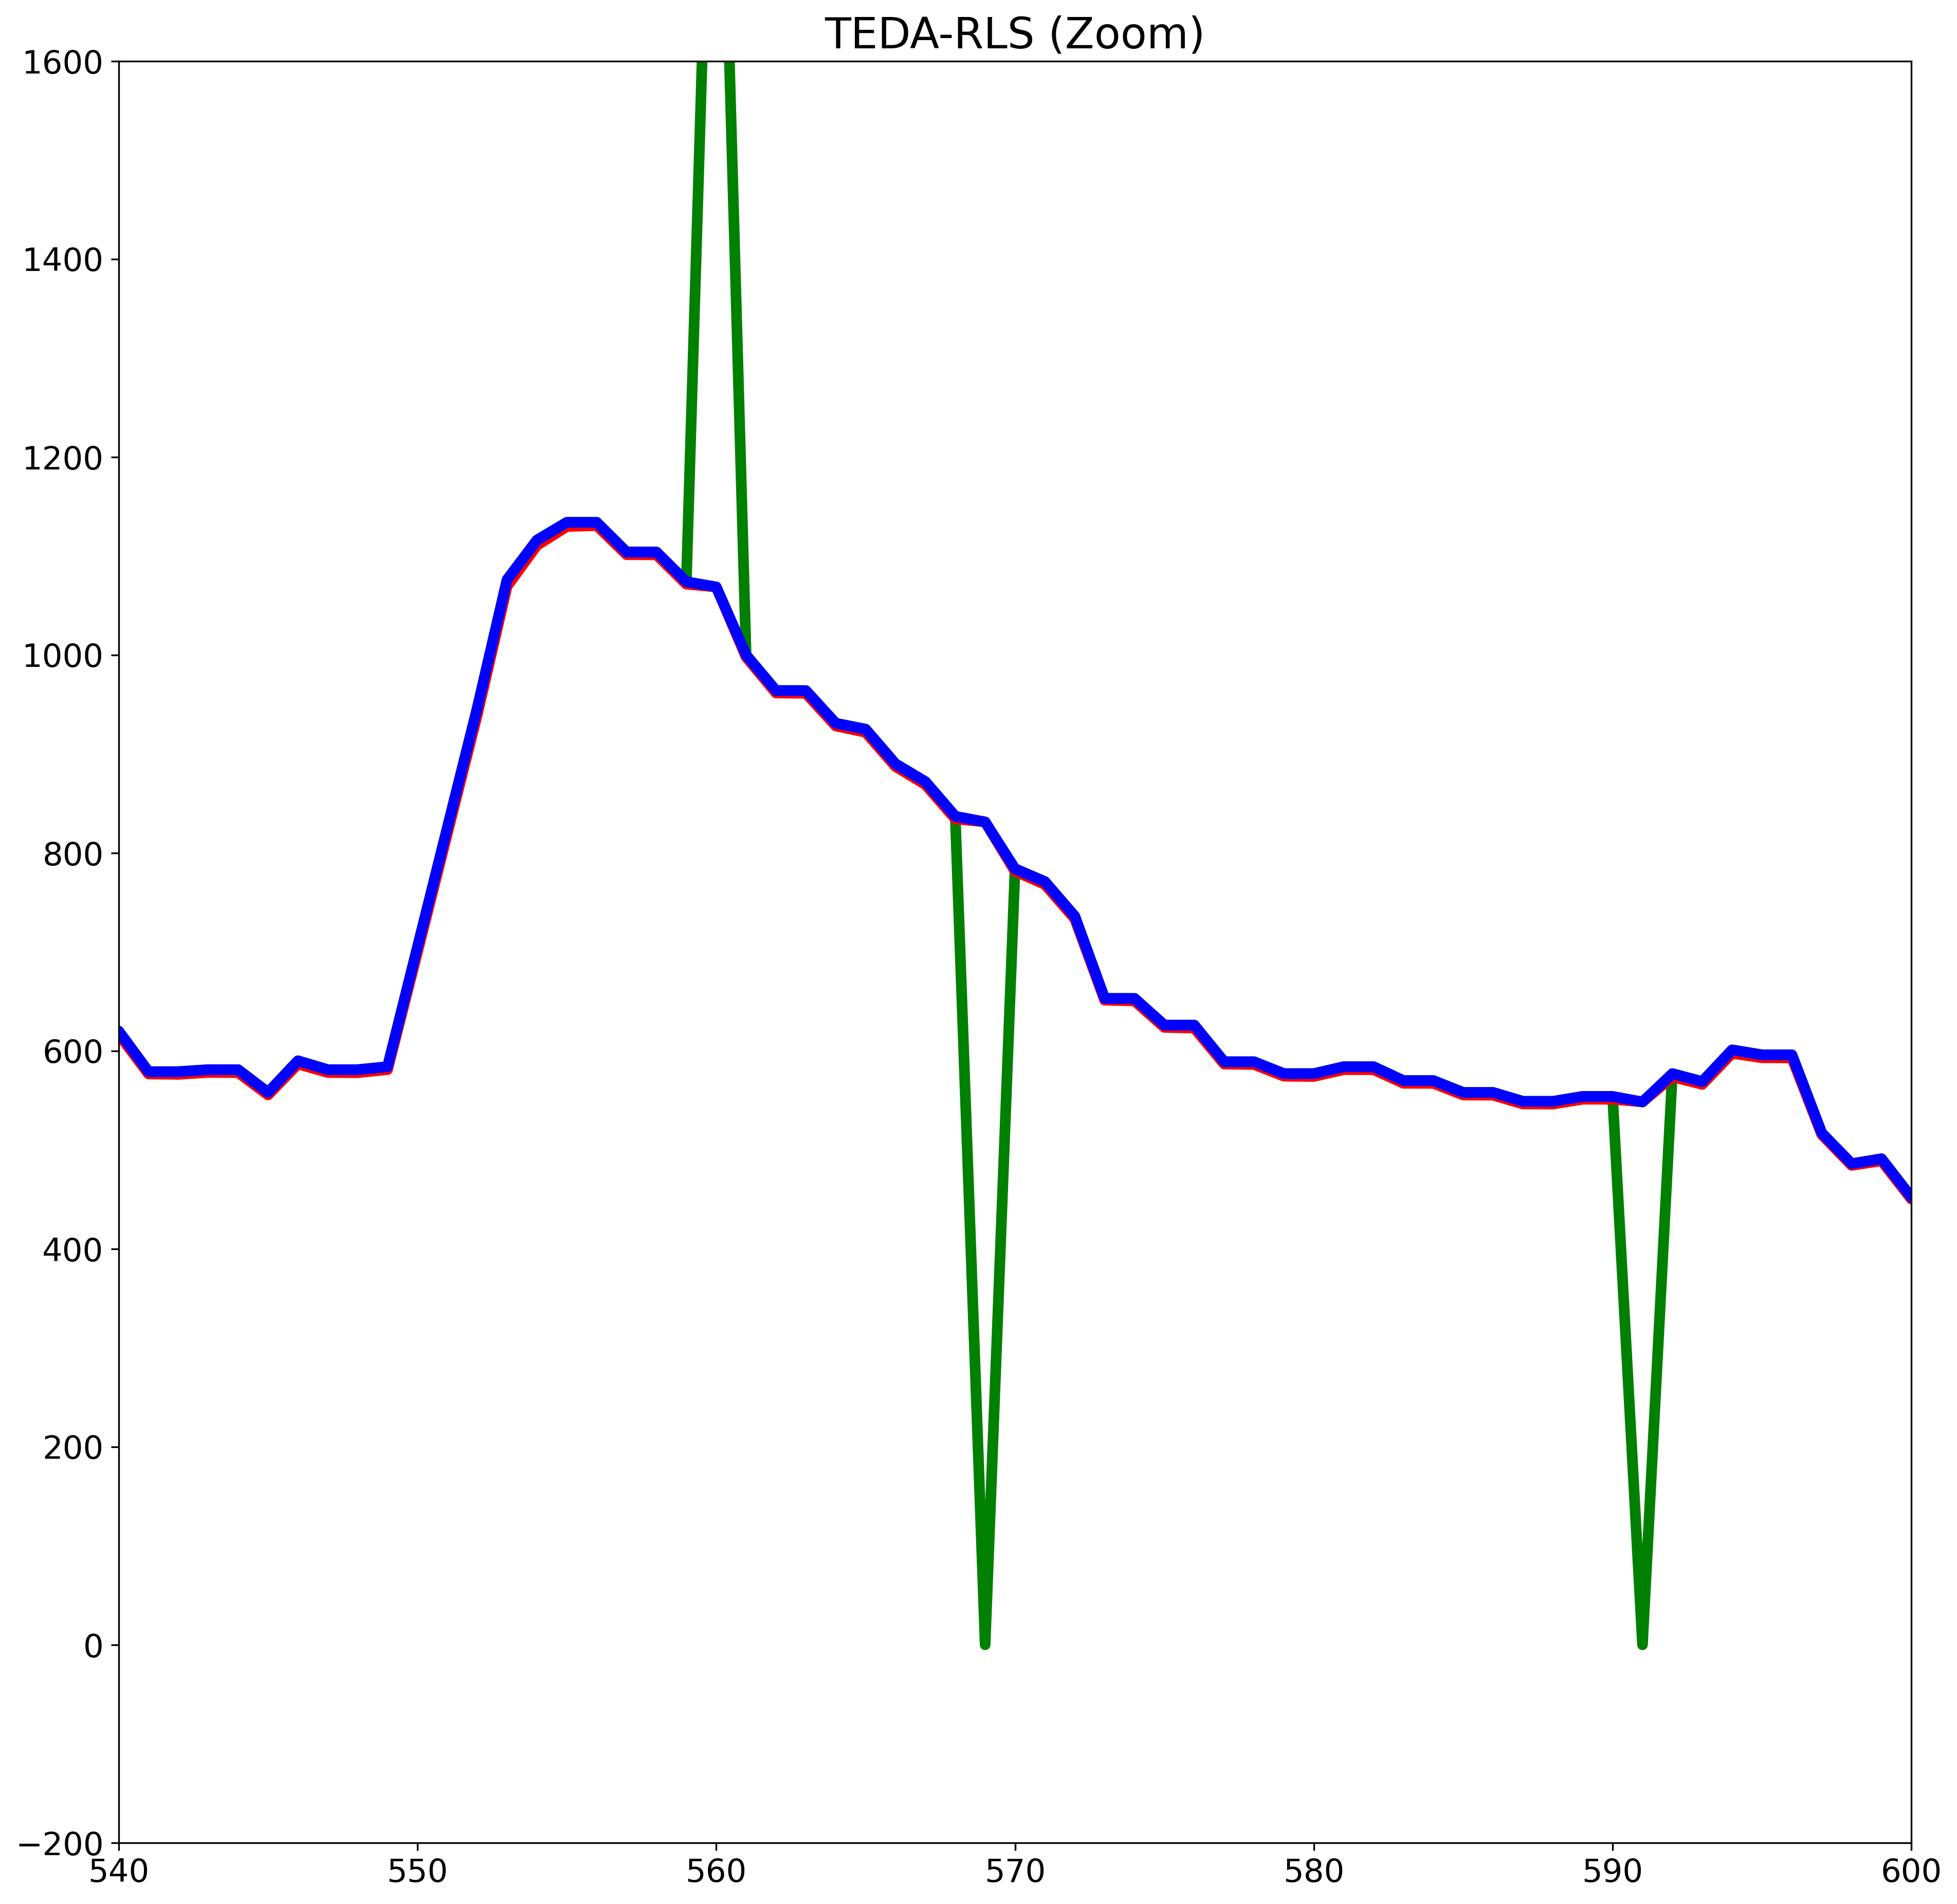

In [27]:
plt.figure(figsize=(15,15), dpi=300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((540, 600))
plt.ylim((-200, 1600))
plt.plot(data['P with outliers'], 'g', linewidth=5)
plt.plot(data['y_pred_py'], 'r', linewidth=5)
plt.plot(data['save_py'], 'b', linewidth=5)
plt.title("TEDA-RLS (Zoom)", fontsize=20)
plt.show()

## 📊 Evaluation Metrics

In this section, we present the metrics used to evaluate the algorithms:

- **TEDA (classification):**
  - We assess the classifier’s performance in detecting typical and eccentric samples.  
  - We use the **classification report** (precision, recall, F1-score) and the **confusion matrix**.  

- **RLS (regression):**
  - We assess the quality of the numerical prediction made by RLS.  
  - We use error metrics such as the **Mean Squared Error (MSE)** and the **Mean Absolute Error (MAE)**.  


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error

### ⚖️ TEDA Metrics

- **Confusion Matrix:** shows the number of correct and incorrect predictions for each class (typical vs. eccentric).  
- **Classification Report:** includes precision, recall, and F1-score, which help to evaluate whether the model is  
  - correctly identifying typical samples,  
  - and not confusing them with eccentric ones.  


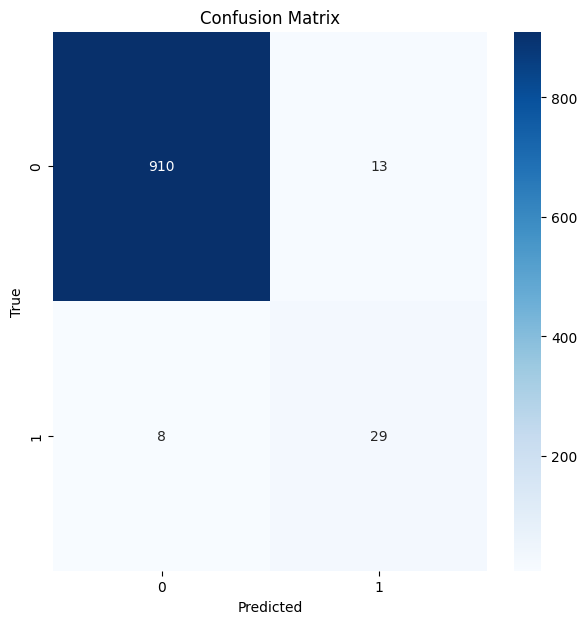

In [29]:
cm = confusion_matrix(data['label'], data['flag_py'])
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [30]:
print(classification_report(data['label'], data['flag_py']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       923
           1       0.69      0.78      0.73        37

    accuracy                           0.98       960
   macro avg       0.84      0.88      0.86       960
weighted avg       0.98      0.98      0.98       960



### 📐 RLS Metrics

- **MSE (Mean Squared Error):**
  $$
  \text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
  $$

  Measures the average squared error → penalizes larger errors more heavily.

- **MAE (Mean Absolute Error):**
  $$
  \text{MAE} = \frac{1}{N} \sum_{i=1}^N |y_i - \hat{y}_i|
  $$

  Measures the average absolute error → more interpretable and robust against large outliers.


In [31]:
start = 0

rmse_pred_py = mean_squared_error(data['P with outliers'].iloc[start:], data['y_pred_py'].iloc[start:])
mae_pred_py = mean_absolute_error(data['P with outliers'].iloc[start:], data['y_pred_py'].iloc[start:])
print("Mean Squared Error (RMSE) - RLS:", rmse_pred_py)
print("Mean Absolute Error (MAE) - RLS:", mae_pred_py)

Mean Squared Error (RMSE) - RLS: 13859.18895959423
Mean Absolute Error (MAE) - RLS: 23.15122318843618
